In [516]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import mutual_info_regression, RFECV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [517]:
data = pd.read_pickle('df_exp1.pkl')
X = data.drop(columns=["N AufgewAmplitudeNom [MPa]"])
y = data["N AufgewAmplitudeNom [MPa]"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [518]:
def preprocess(X, X_train, X_test):
    categorical_features = X.select_dtypes(include=['object']).columns.tolist()
    numerical_features = X.select_dtypes(include=['number']).columns.tolist()
    
    numerical_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('encoder', OrdinalEncoder())
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ]
    )

    preprocessor.fit(X_train)

    X_train = preprocessor.transform(X_train)
    X_test = preprocessor.transform(X_test)

    return X_train, X_test

In [519]:
X_train, X_test = preprocess(X, X_train, X_test)
rf = RandomForestRegressor(random_state=0, n_jobs=4)
rf.fit(X_train, y_train)

RandomForestRegressor(n_jobs=4, random_state=0)

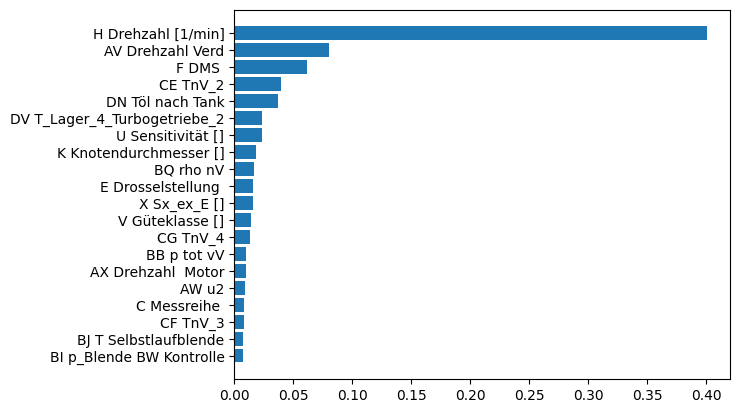

In [520]:
f_i = list(zip(X.columns, rf.feature_importances_))
f_i.sort(key = lambda x : x[1])
f_i = f_i[-20:]
plt.barh([x[0] for x in f_i],[x[1] for x in f_i])
plt.show()

In [664]:
indices = np.argsort(rf.feature_importances_)[::-1]
selected_features_rf = X.columns[indices[:15]]

In [187]:
rfe = RFECV(rf, cv=5, scoring="neg_mean_squared_error", n_jobs=4)
rfe.fit(X_train, y_train)

KeyboardInterrupt: 

In [49]:
selected_features_rfe = np.array(X.columns)[rfe.get_support()]
selected_features_rfe

array(['F DMS ', 'G Zeit [s]', 'H Drehzahl [1/min]', 'J Frequenz [Hz]',
       'U Sensitivität []', 'W ex_ey []', 'AS Drossel Drucks.',
       'AX Drehzahl  Motor', 'BA Umgebungsdruck Kontrolle', 'BM m V red',
       'BS T-Luftfeuchte', 'BV TvV_2', 'CG TnV_4', 'CI TnV_6',
       'CL p_stat_SEALING-COVER_01', 'DQ T_Axiallager 2'], dtype=object)

In [665]:
X_selected = X[selected_features_rf]
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_selected, y, test_size=0.3, random_state=42)

In [666]:
X_train_1, X_test_1 = preprocess(X_selected, X_train_1, X_test_1)

In [567]:
lr_model = LinearRegression()
lr_model.fit(X_train_1, y_train_1)
y_pred_lr_model = lr_model.predict(X_test_1)
mse_lr_model = mean_squared_error(y_test_1, y_pred_lr_model)
print("Linear Regression MSE:", mse_lr_model)

Linear Regression MSE: 37.66861912707881


In [568]:
dt_model = DecisionTreeRegressor(random_state=0)
dt_model.fit(X_train_1, y_train_1)
y_pred_dt_model = dt_model.predict(X_test_1)
mse_dt_model = mean_squared_error(y_test_1, y_pred_dt_model)

param_grid_dt_model = {
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}
grid_search_dt_model = GridSearchCV(dt_model, param_grid_dt_model, cv=5, scoring='neg_mean_squared_error', n_jobs=4)
grid_search_dt_model.fit(X_train_1, y_train_1)

best_dt_model = grid_search_dt_model.best_estimator_
y_pred_dt_model_hyper = best_dt_model.predict(X_test_1)
mse_dt_model_hyper = mean_squared_error(y_test_1, y_pred_dt_model_hyper)
print("Decision Tree MSE:", mse_dt_model)
print("Hyperparameter Decision Tree MSE:", mse_dt_model_hyper)
print("Best Decision Tree Params:", grid_search_dt_model.best_params_)

Decision Tree MSE: 3.719132922640474
Hyperparameter Decision Tree MSE: 3.7581952816019446
Best Decision Tree Params: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [693]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, l1, l2,  output_size):
        super().__init__()
        self.linear1 = nn.Linear(input_size, l1)
        self.linear2 = nn.Linear(l1, l2)
        self.linear3 = nn.Linear(l2, output_size)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.linear3(x)
        return x

In [694]:
model = NeuralNetwork(15, 8, 4, 1)

loss_module = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [695]:
X_train_tensor = torch.tensor(X_train_1, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_1, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_1, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_1.to_numpy(), dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [700]:
def train_model(model, optimizer, loss_module, train_loader, epochs=100):
    model.train()
    for epoch in range(epochs):
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_module(outputs, targets)
            loss.backward()
            optimizer.step()

In [697]:
def evaluate_model(model, test_loader, loss_module):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = loss_module(outputs, targets)
            total_loss += loss.item()
    
    average_loss = total_loss / len(test_loader)
    print(f"Test Loss: {average_loss}")
    return average_loss


In [698]:
train_model(model, optimizer, loss_module, train_loader, epochs=5000)

In [699]:
evaluate_model(model, test_loader, loss_module)

Test Loss: 41.47043433808189


41.47043433808189

In [674]:
from itertools import product

learning_rates = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
l1 = [4, 8, 16, 32]
l2 = [4, 8, 16]

hyperparameter_combinations = list(product(learning_rates, l1, l2))

In [675]:
best_loss = float('inf')
best_params = None
best_model = None

for lr, l1, l2 in hyperparameter_combinations:
    model = NeuralNetwork(input_size=15, l1=l1, l2=l2, output_size=1)
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)
    
    print(f"Training with lr={lr}, hidden1={l1}, hidden2={l2}")
    train_model(model, optimizer, loss_module, train_loader, epochs=50)
    test_loss = evaluate_model(model, test_loader, criterion)
    
    if test_loss < best_loss:
        best_loss = test_loss
        best_params = (lr, l1, l2)
        best_model = model

print(f"Best Loss: {best_loss}")
print(f"Best Params: Learning Rate={best_params[0]}, Hidden1={best_params[1]}, Hidden2={best_params[2]}")


Training with lr=0.001, hidden1=4, hidden2=4
Epoch [1/50], Loss: 69.69173276932513


/Users/vb/projects/MAN-ml-project/venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/vb/projects/MAN-ml-project/venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([48])) that is different to the input size (torch.Size([48, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [2/50], Loss: 44.64548655025295
Epoch [3/50], Loss: 44.63651178391253
Epoch [4/50], Loss: 44.623649347023886
Epoch [5/50], Loss: 44.629998322783926
Epoch [6/50], Loss: 44.61096170769363
Epoch [7/50], Loss: 44.63733670281582
Epoch [8/50], Loss: 44.618929859849274
Epoch [9/50], Loss: 44.61622520821994
Epoch [10/50], Loss: 44.60828386838319
Epoch [11/50], Loss: 44.60249194160836
Epoch [12/50], Loss: 44.64033391983783
Epoch [13/50], Loss: 44.619784333275966
Epoch [14/50], Loss: 44.59896064508157
Epoch [15/50], Loss: 44.62060247327461
Epoch [16/50], Loss: 44.624217261642706
Epoch [17/50], Loss: 44.62200493734391
Epoch [18/50], Loss: 44.62235969168241
Epoch [19/50], Loss: 44.627219403376344
Epoch [20/50], Loss: 44.6144962185719
Epoch [21/50], Loss: 44.614820374035446
Epoch [22/50], Loss: 44.634568492701796
Epoch [23/50], Loss: 44.6062069001745
Epoch [24/50], Loss: 44.61867786157327
Epoch [25/50], Loss: 44.61031502895668
Epoch [26/50], Loss: 44.62045262446169
Epoch [27/50], Loss: 44.638

/Users/vb/projects/MAN-ml-project/venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [2/50], Loss: 44.79766516138296
Epoch [3/50], Loss: 44.77346752667036
Epoch [4/50], Loss: 44.701930311859634
Epoch [5/50], Loss: 44.70416608403941
Epoch [6/50], Loss: 44.74438298960201
Epoch [7/50], Loss: 44.739250089301436
Epoch [8/50], Loss: 44.75087171460761
Epoch [9/50], Loss: 44.72646034741011
Epoch [10/50], Loss: 44.72859086834016
Epoch [11/50], Loss: 44.699225844711556
Epoch [12/50], Loss: 44.71837844848633
Epoch [13/50], Loss: 44.70812491119885
Epoch [14/50], Loss: 44.67697618828445
Epoch [15/50], Loss: 44.68841822264624
Epoch [16/50], Loss: 44.69538296558818
Epoch [17/50], Loss: 44.72817788045914
Epoch [18/50], Loss: 44.683219390618994
Epoch [19/50], Loss: 44.6995849734447
Epoch [20/50], Loss: 44.66862213259838
Epoch [21/50], Loss: 44.71946004648677
Epoch [22/50], Loss: 44.71544822317655
Epoch [23/50], Loss: 44.65639320748751
Epoch [24/50], Loss: 44.70897717085041
Epoch [25/50], Loss: 44.69381074749055
Epoch [26/50], Loss: 44.735061160853654
Epoch [27/50], Loss: 44.67920